In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
import rmutils as rm
from collections import OrderedDict
import numba
from gglib.datamgmt.simpleio import *
%matplotlib inline

The imports are copied to the clipboard


In [2]:
import variograms

In [3]:
def exportfigure(filename, **kwargs):
    gs.exportimg(os.path.join('figures/', filename), **kwargs)

In [4]:
points = gg.PointContainer('nilat_maincats.dat')

In [5]:
nreal = 100
points['nodomains'] = 1
ltrim = -999
nprocesses = 5
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

# checkout some variogram maps for directions

In [6]:
lagpars = dict(nx=10, dx=35, ny=10, dy=35, nz=10, dz=2)

In [7]:
varmap = variograms.VarMapPoint(points, var=variables, itype=4, **lagpars).run()

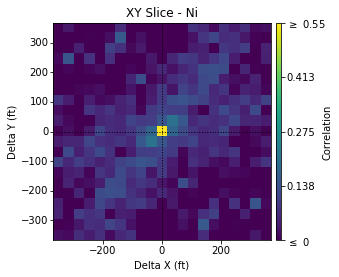

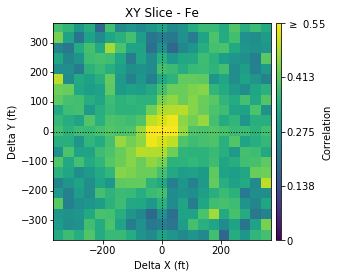

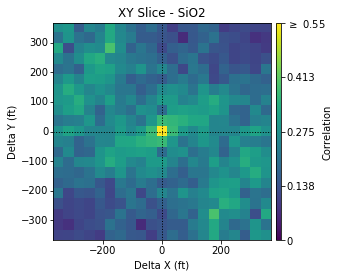

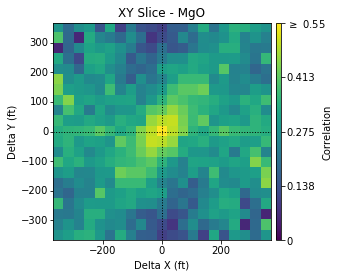

In [8]:
varmap.plot_maps(vlim=(0, 0.55))

In [9]:
varmap = variograms.VarMapPoint(points, catcol='modelcats', **lagpars).run()

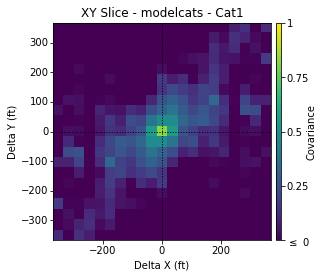

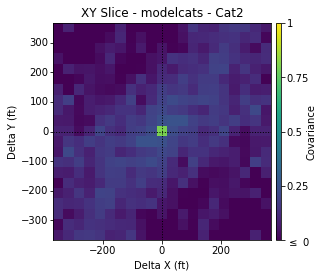

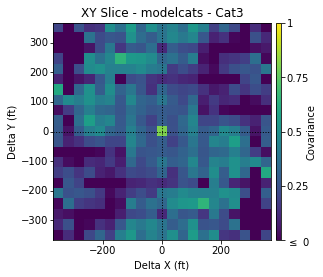

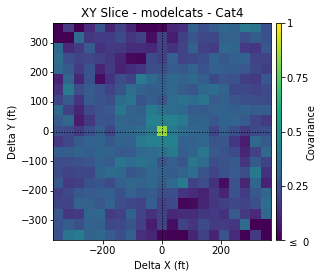

In [10]:
varmap.plot_maps('xy')

# setup the variograms

In [26]:
variables = variables
catcols = ['nodomains', 'modelcats', 'mvclus', 'agglom', 'betteragglom']
realscatcols = [[f'clusreal{i}' for i in range(nreal)], 
                [f'randreal{i}' for i in range(nreal)]]
catbases = ['reals_ensbest', 'reals_random']

In [27]:
names = ['reals_ensbest', 'reals_random', 'modelcats', 'mvclus', 'agglom', 'betteragglom', 'nodomains']
titles = ["Category Realizations",
          "Random Domains", "Geological Categories", 
          "Multivariate Clusters", "Spatial Clusters", "Improved Spatial Clusters",
          "No Domains"]
titles = OrderedDict([(k, t) for k, t in zip(names, titles)])

# cat variogram models

## parameters

In [28]:
# Cat Variogram Pars
catcalcpars = {
    1:  dict(azm=50, azmtol=15, 
             nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
             bandvert=3),
    2:  dict(azm=50, azmtol=15, 
             nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
             bandvert=3),
    3:  dict(azm=135, azmtol=15, 
             nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
             bandvert=3),
    4:  dict(azm=45, azmtol=15, 
             nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
             bandvert=3),
}
catmodelpars = {
    1:  dict(nst=3, it=1, c0=[0.0, 0.0], 
             ahmax=[[50, 9999999], [100, 9999999], [100, 9999999]],
             ahmin=[[50, 9999999], [100, 9999999], [100, 9999999]],
             avert=[[5, 150], [10, 1e21], [10, 1e21]]),
    2:  dict(nst=3, it=1, c0=[0.0, 0.0], 
             ahmax=[[50, 9999999], [100, 9999999], [100, 9999999]],
             ahmin=[[50, 9999999], [100, 9999999], [100, 9999999]],
             avert=[[5, 150], [10, 1e21], [10, 1e21]]),
    3:  dict(nst=3, it=1, c0=[0.0, 0.0], 
             ahmax=[[50, 9999999], [100, 9999999], [100, 9999999]],
             ahmin=[[50, 9999999], [100, 9999999], [100, 9999999]],
             avert=[[5, 150], [10, 1e21], [10, 1e21]]),
    4:  dict(nst=3, it=1, c0=[0.0, 0.0], 
             ahmax=[[50, 9999999], [100, 9999999], [100, 9999999]],
             ahmin=[[50, 9999999], [100, 9999999], [100, 9999999]],
             avert=[[5, 150], [10, 1e21], [10, 1e21]])
}

## calc and fit

In [29]:
from rmutils import varcalc_parallel, varfit_parallel

In [30]:
catvarios = {}
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    if ucats.shape[0] == 1:
        continue
    for cat in ucats:
        vario = gs.Variogram(points, catcol, ndim=3, ndir=3, omnihz=False, variostd=True,
                             mute=True)
        vario.inferdirections(0)
        vario.update_calcpars(variotypes=10, variocutcat=[[cat, cat]],
                              diptol=10.5, **catcalcpars[cat])
        vario.update_modelpars(**catmodelpars[cat])
        catvarios[catcol, cat] = vario
varcalc_parallel(catvarios, nprocesses=nprocesses)
varfit_parallel(catvarios, c0=[0, 0.1], it=1, minrange=10, maxrange=10000, nst=3, 
                nprocesses=nprocesses)

## plot the single-reals catvarios

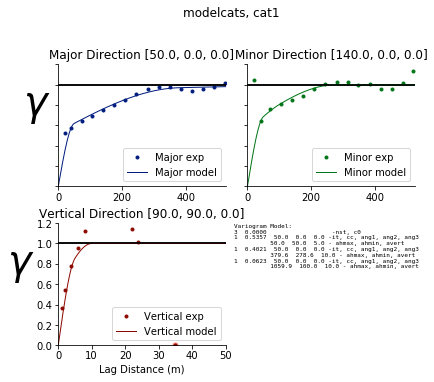

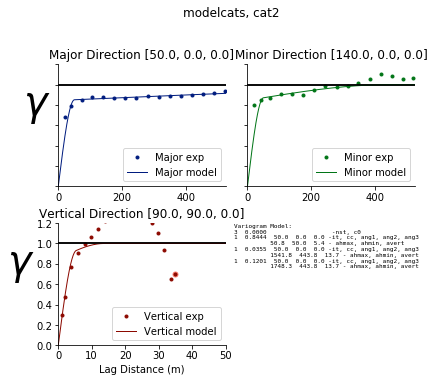

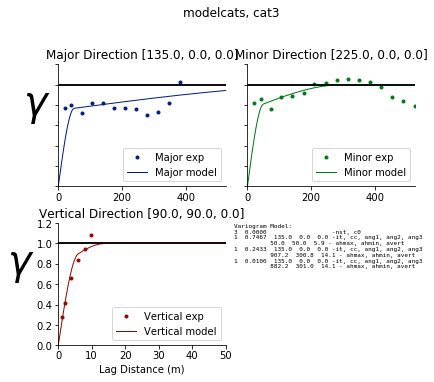

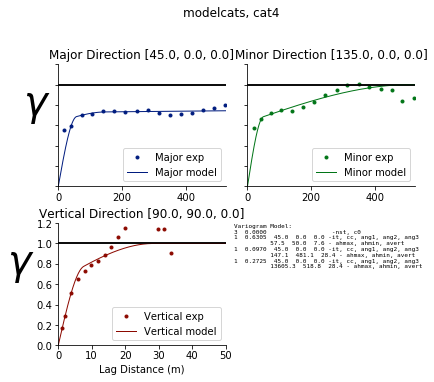

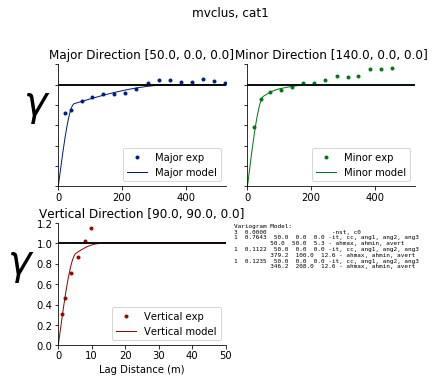

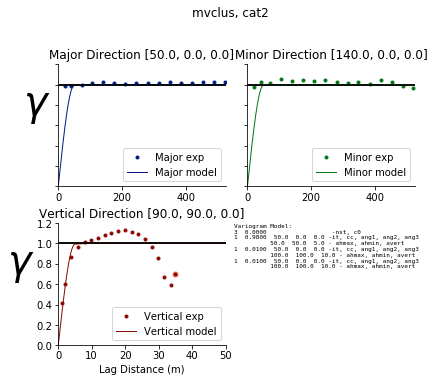

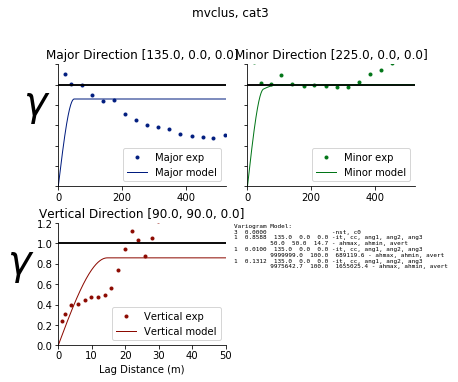

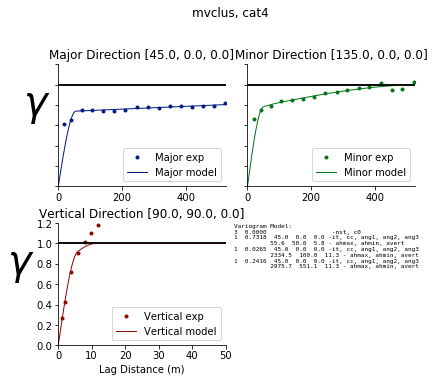

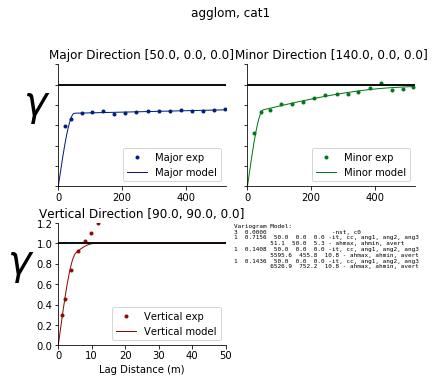

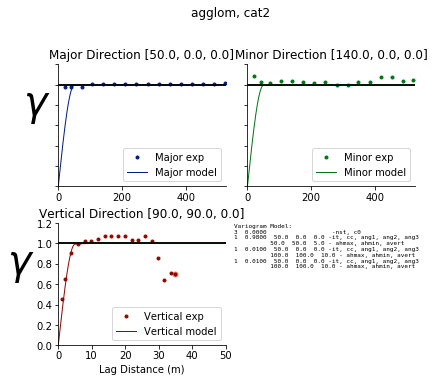

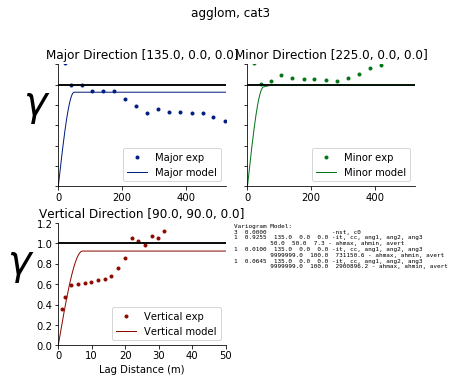

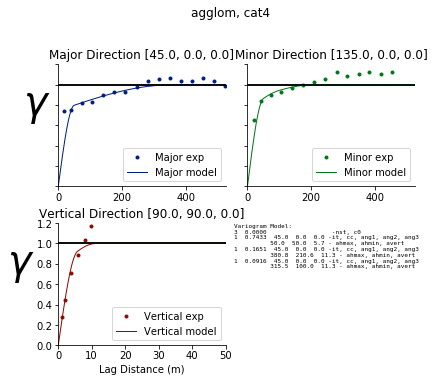

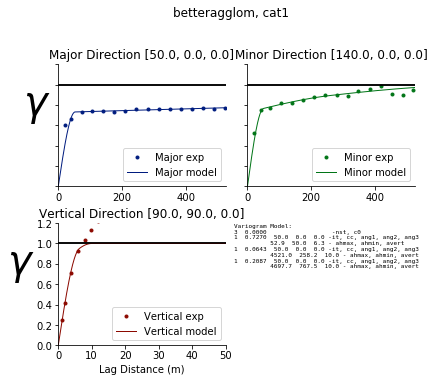

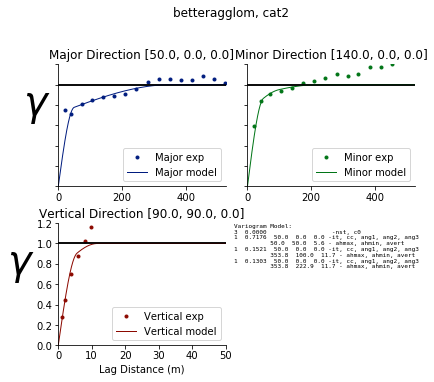

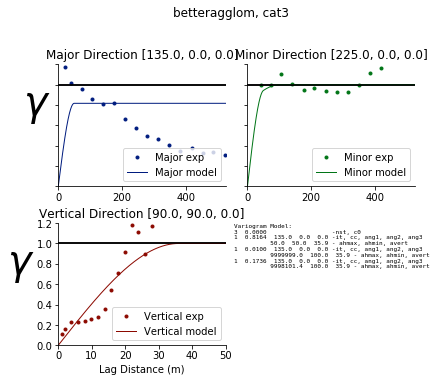

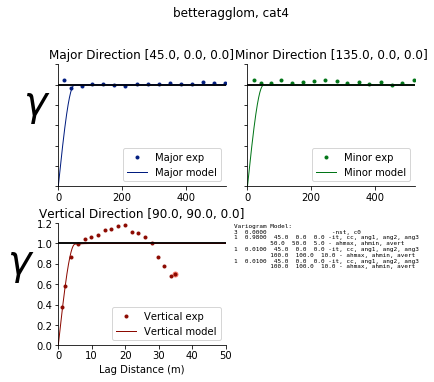

In [31]:
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    ncats = len(ucats)
    if ncats == 1:
        continue
    for cat in ucats:
        catvarios[catcol, cat].plot(model=True, printmodel=True, suptitle=f'{catcol}, cat{cat}',
                                    varplt_kws={'exp': {'ms': 3}})

## write out the catmodels

In [32]:
catmodels = {k: str(v.model) for k, v in catvarios.items()}
# add the betteragglomg vario for the realizations of cats
for catcol in realscatcols[0]:
    for cat in ucats:
        catmodels[catcol, cat] = catmodels['betteragglom', cat]
# add the random domains for each category
for catcol in realscatcols[1]:
    for cat in ucats:
        catmodels[catcol, cat] = "1 0.000 \n 1 1 0 0 0 \n 5 5 5 "
gg.save_pickle(catmodels, f'catvarmodels.pkl')

# continuous variogram models

In [33]:
# Continuous Variogram Pars
contcalcpars = {
    'Ni': {
        1:  dict(azm=45, azmtol=15, 
                 nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
                 bandvert=3),
        2:  dict(azm=45, azmtol=15, 
                 nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
                 bandvert=3),
        3:  dict(azm=45, azmtol=15, 
                 nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
                 bandvert=3),
        4:  dict(azm=45, azmtol=15, 
                 nlags=[15, 15, 25], lagdist=[35, 35, 2], lagtol=[25, 25, 1.2], 
                 bandvert=3),
    }
}
for var in variables[1:]:
    contcalcpars[var] = contcalcpars['Ni'].copy()
    
contmodelpars = {
    'Ni': {
        1:  dict(nst=3, it=1, c0=[0.0, 0.0], 
                 ahmax=[[50, 500], [100, 9999999], [500, 9999999]],
                 ahmin=[[50, 500], [100, 9999999], [500, 9999999]],
                 avert=[[5, 10], [5, 1e21], [20, 1e21]]),
        2:  dict(nst=3, it=1, c0=[0.0, 0.0], 
                 ahmax=[[50, 500], [100, 9999999], [500, 9999999]],
                 ahmin=[[50, 500], [100, 9999999], [500, 9999999]],
                 avert=[[5, 10], [5, 1e21], [20, 1e21]]),
        3:  dict(nst=3, it=1, c0=[0.0, 0.0], 
                 ahmax=[[50, 9999999], [100, 9999999], [500, 9999999]],
                 ahmin=[[50, 9999999], [100, 9999999], [500, 9999999]],
                 avert=[[5, 10], [5, 1e21], [20, 1e21]]),
        4:  dict(nst=3, it=1, c0=[0.0, 0.0], 
                 ahmax=[[50, 9999999], [100, 9999999], [500, 9999999]],
                 ahmin=[[50, 9999999], [100, 9999999], [500, 9999999]],
                 avert=[[5, 10], [5, 1e21], [20, 1e21]]),
    }
}
for var in variables[1:]: # copy
    contmodelpars[var] = contmodelpars['Ni'].copy()

In [34]:
nsvarios = {}
## SINGLE REALS
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    # normal score transform within each category
    nstrans = gg.GaussTrans(points, invars=variables, catcol=catcol, ltrim=-999)
    nsvars, _ = nstrans.forwardtrans(inplace=True)
    nsvariables = nsvars.columns
    for cat in ucats:
        for var, nsvar in zip(variables, nsvariables):
            vario = gs.Variogram(points, nsvar, ndim=3, ndir=3, omnihz=False, variostd=True,
                                 mute=True, tmin=ltrim, catpars=(catcol, cat))
            vario.inferdirections(0)
            vario.update_calcpars(variotypes=1, diptol=10.5, 
                                  **contcalcpars[var][cat])
            vario.update_modelpars(**contmodelpars[var][cat])
            nsvarios[catcol, cat, var] = vario

varcalc_parallel(nsvarios, nprocesses=nprocesses)
varfit_parallel(nsvarios, c0=[0, 0.1], it=[1, 1], minrange=10, maxrange=999999, nst=3, 
                nprocesses=nprocesses)

## plot single reals nsvarios

In [35]:
mpl.rcParams['figure.max_open_warning'] = 500

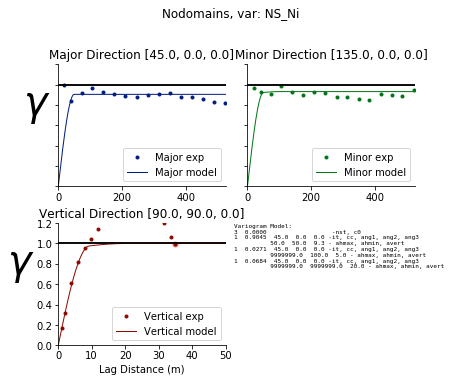

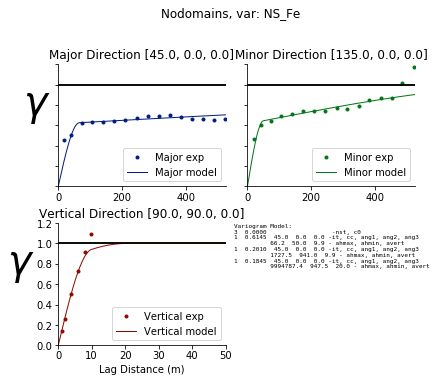

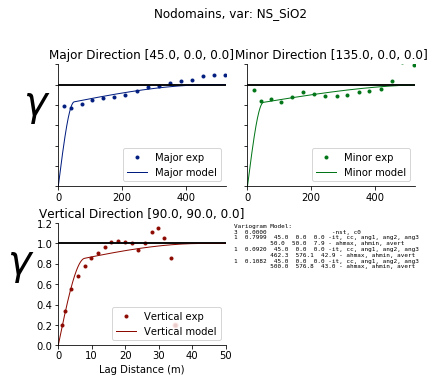

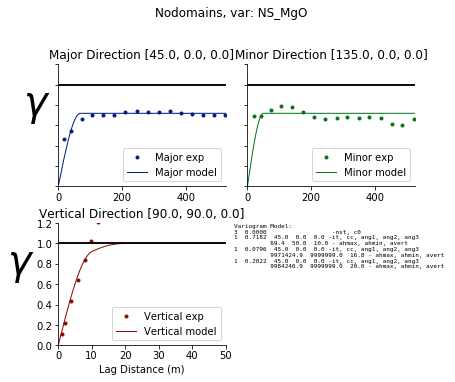

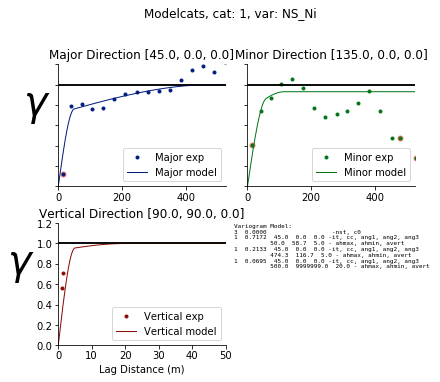

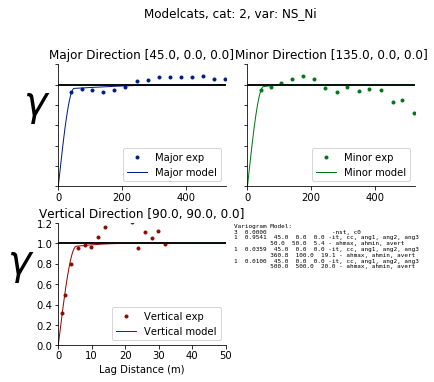

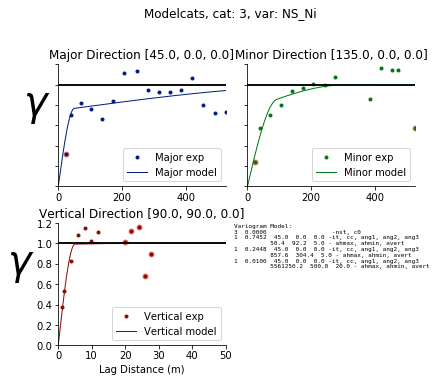

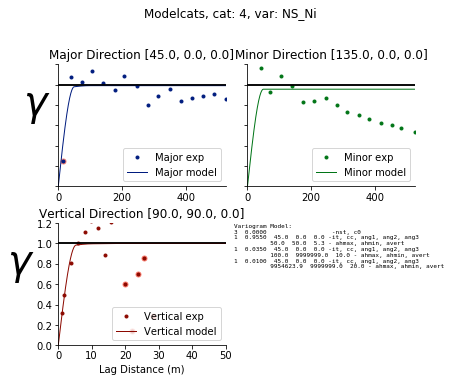

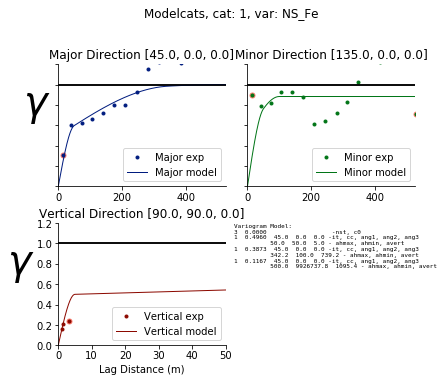

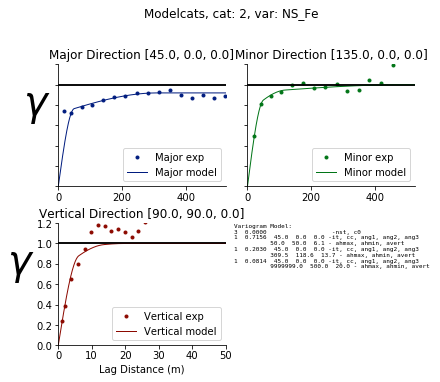

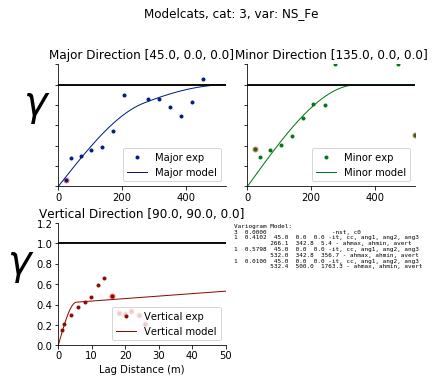

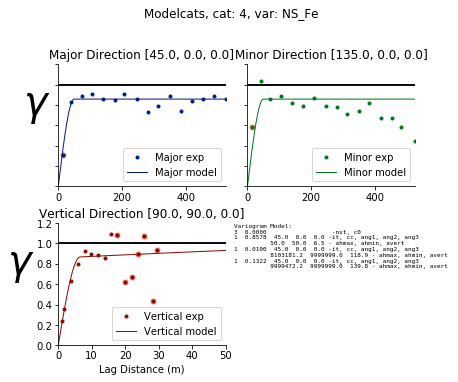

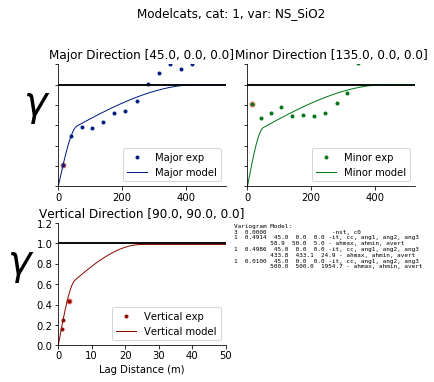

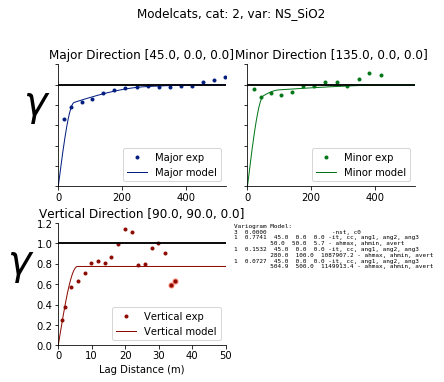

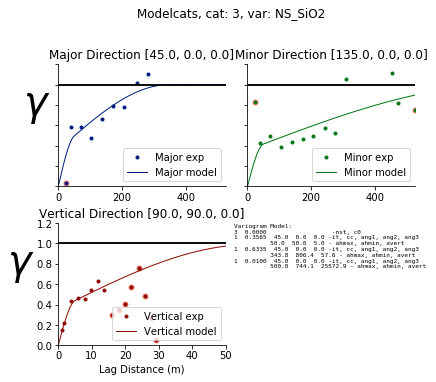

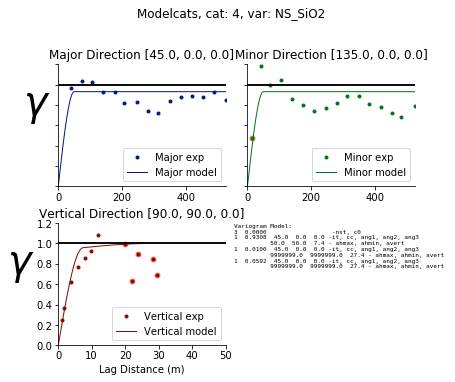

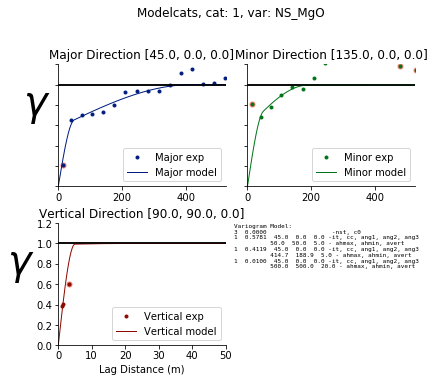

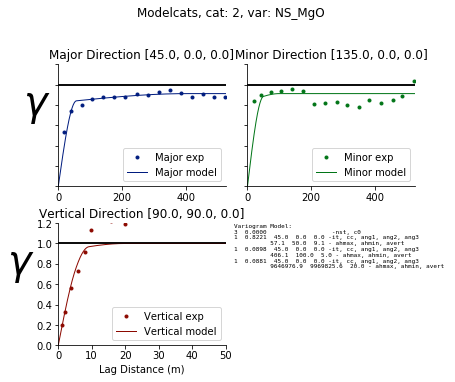

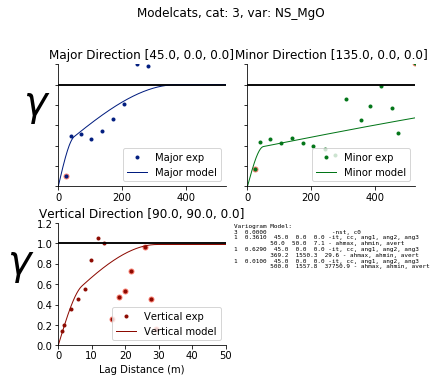

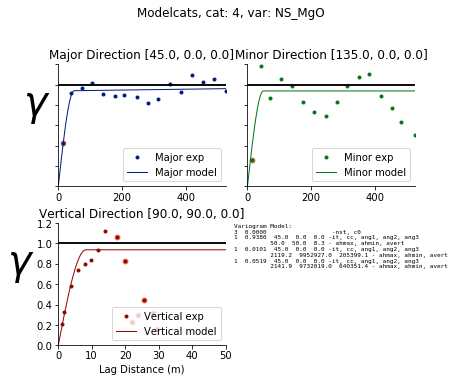

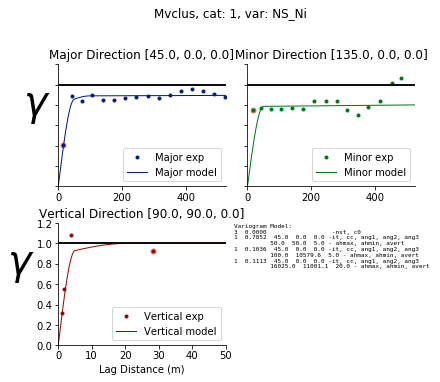

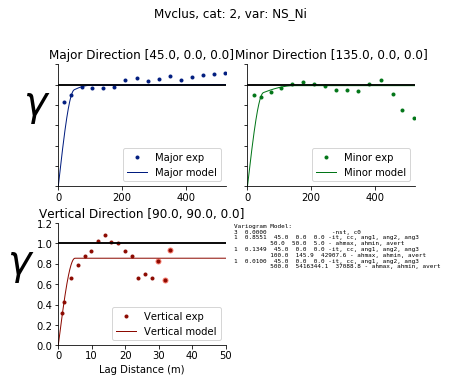

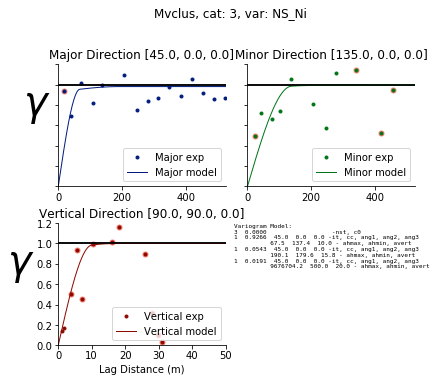

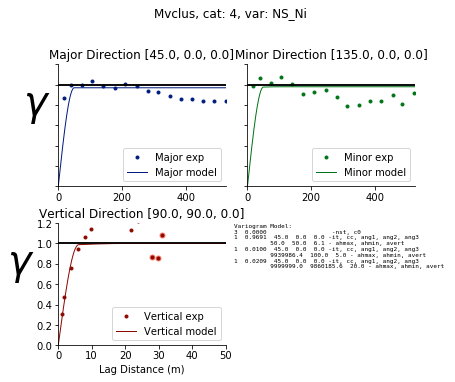

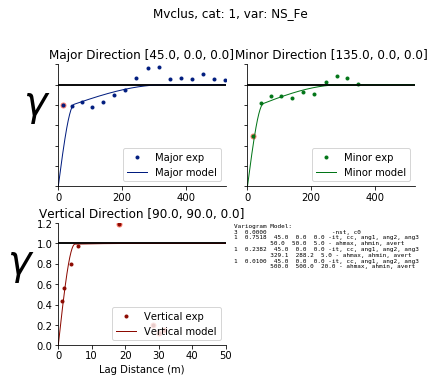

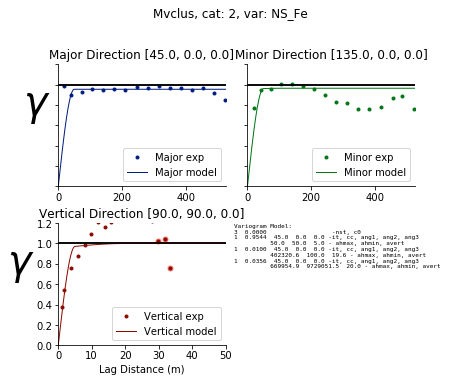

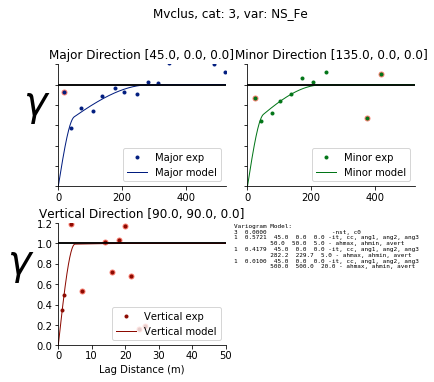

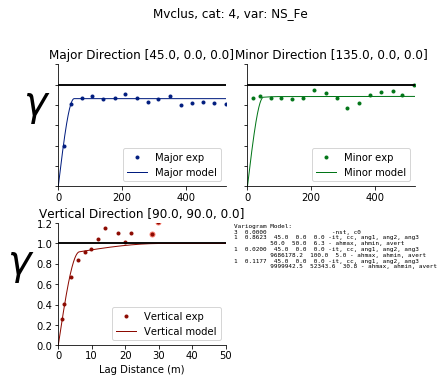

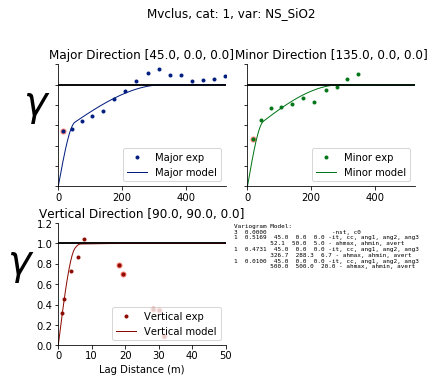

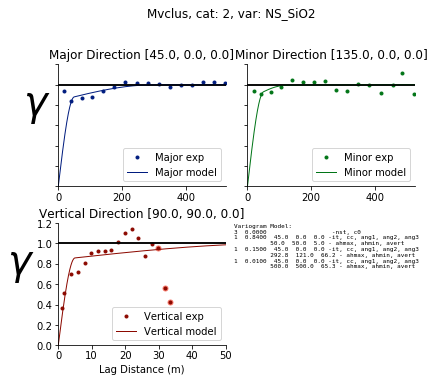

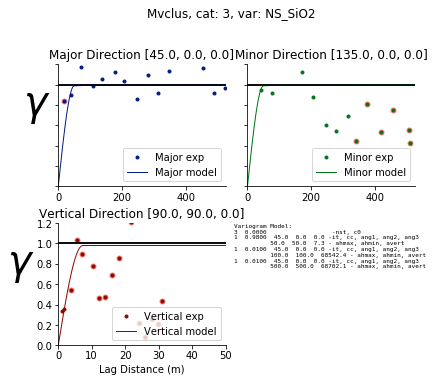

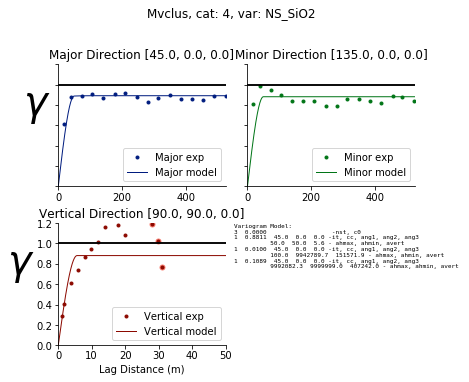

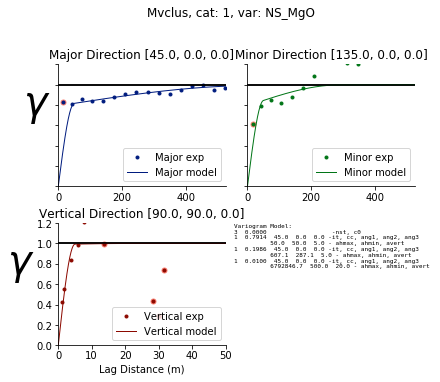

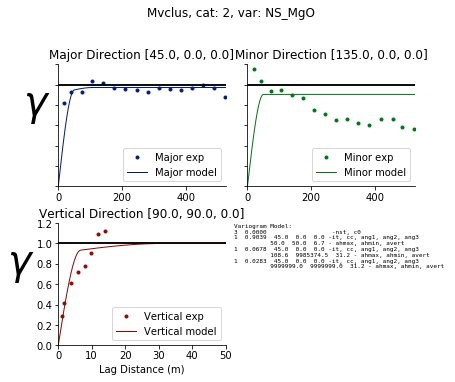

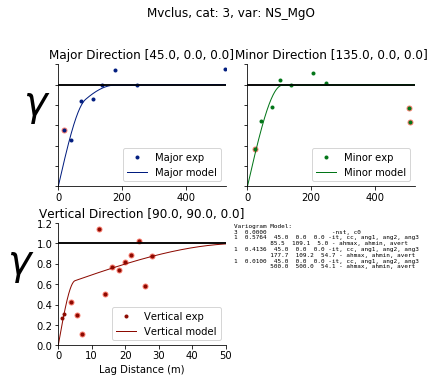

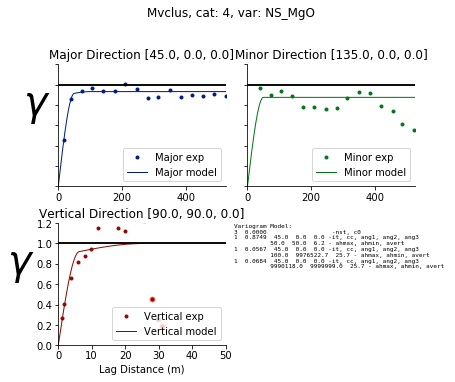

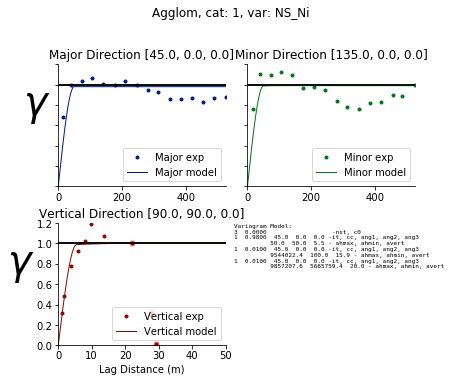

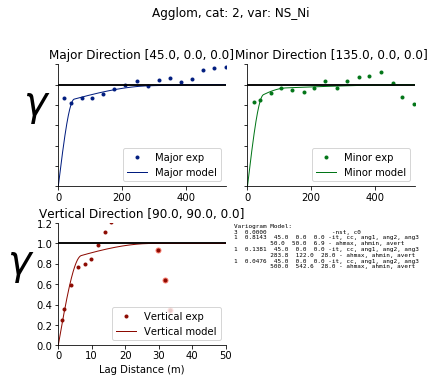

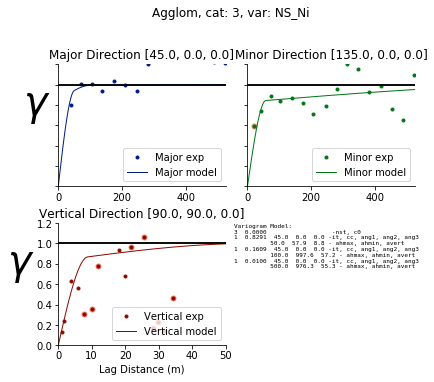

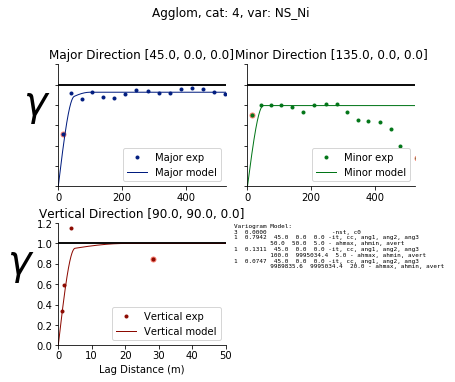

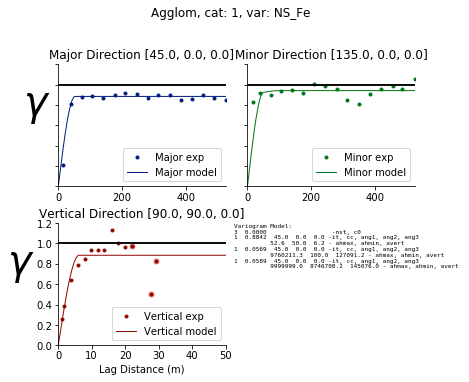

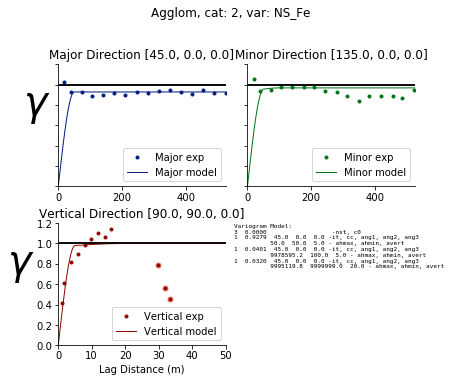

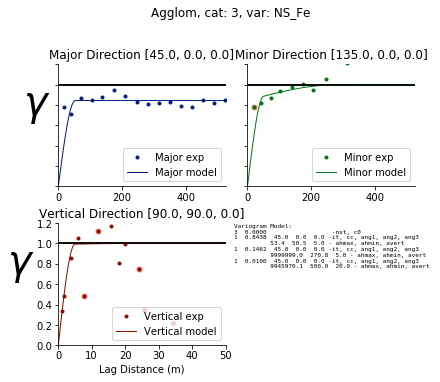

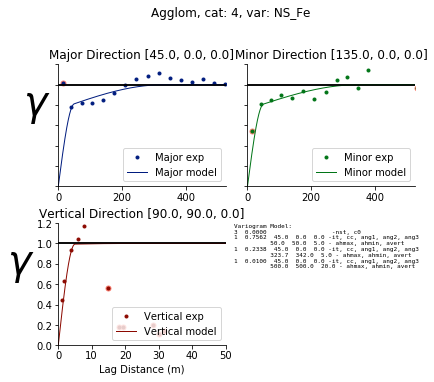

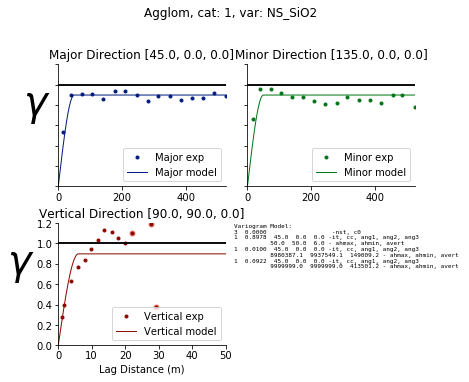

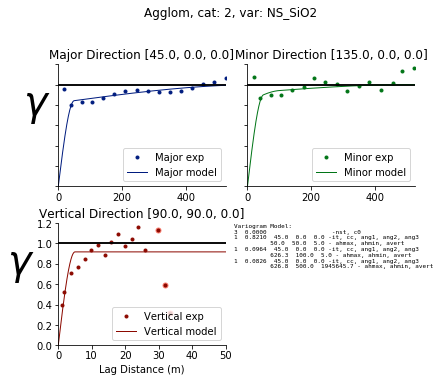

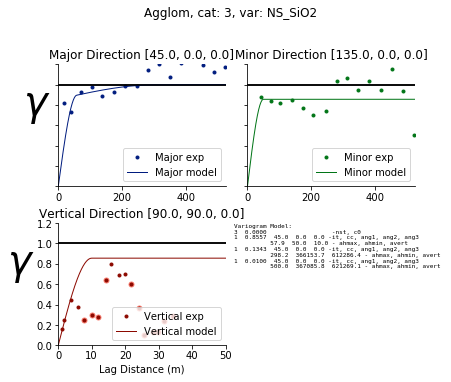

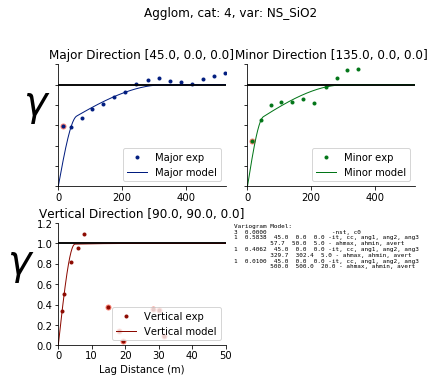

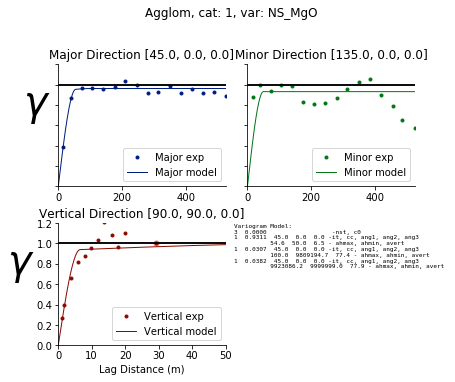

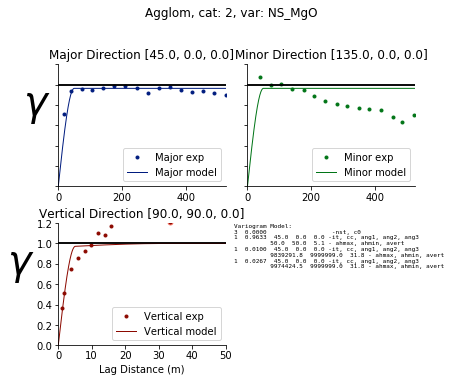

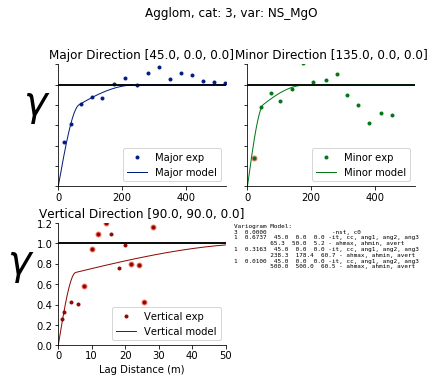

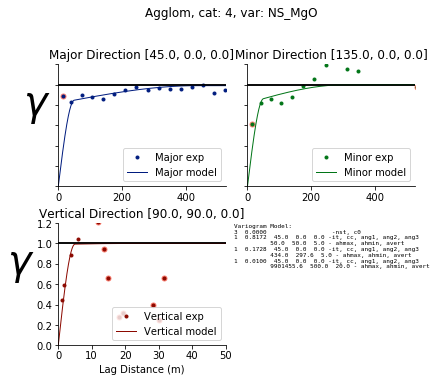

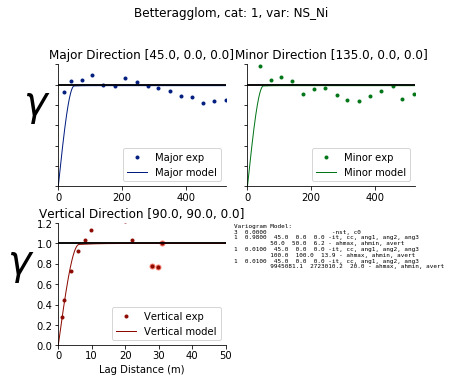

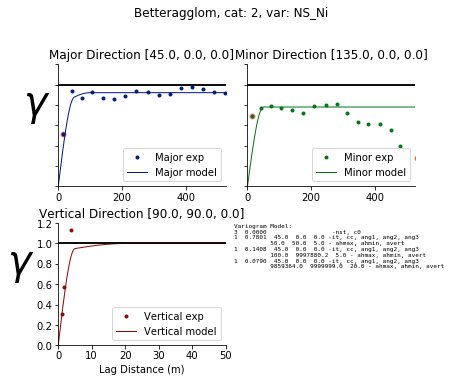

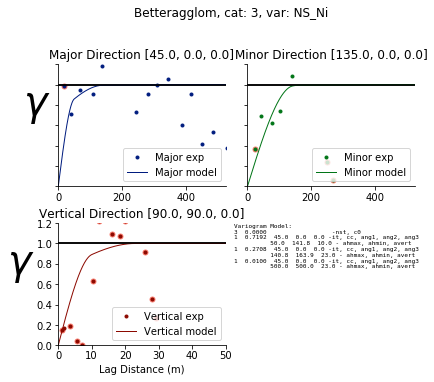

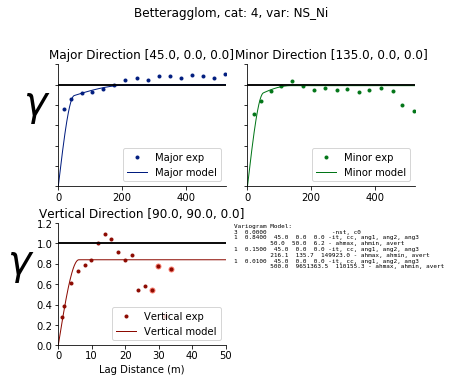

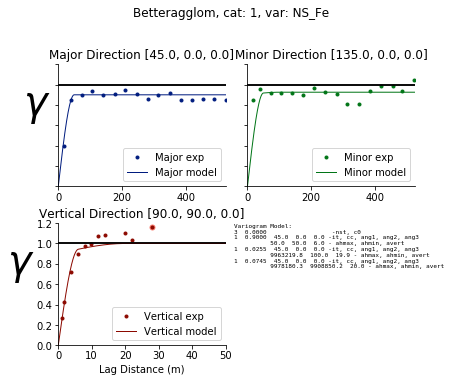

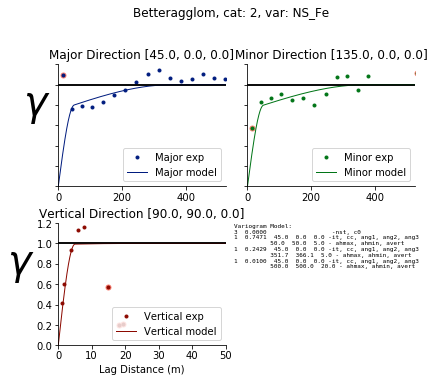

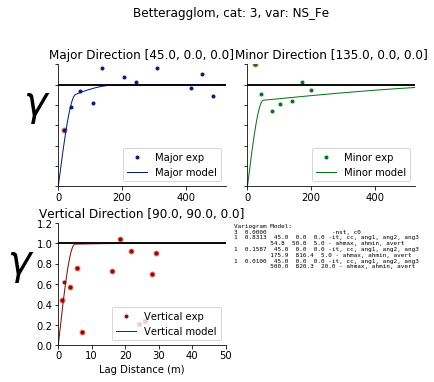

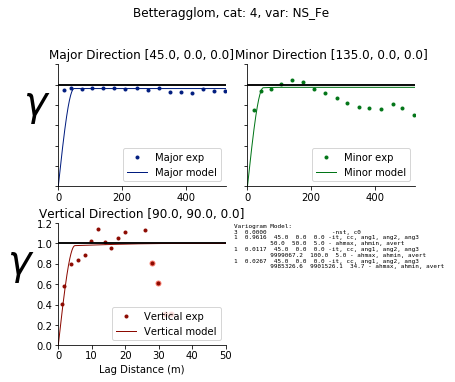

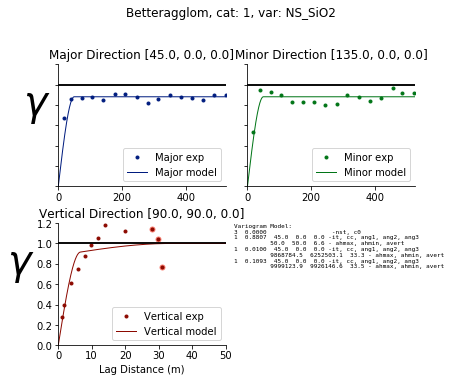

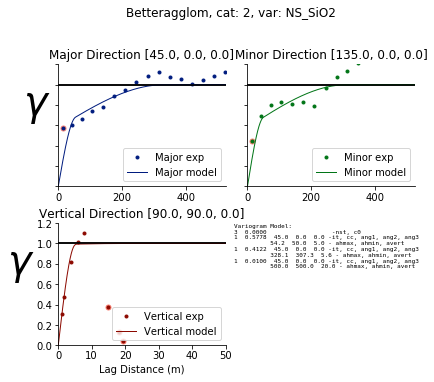

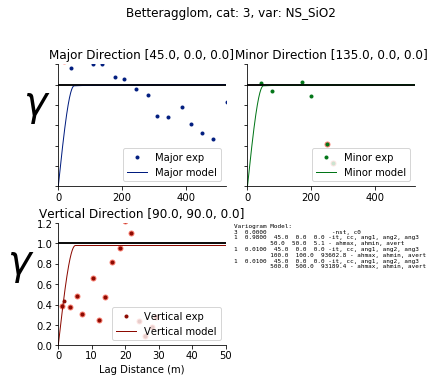

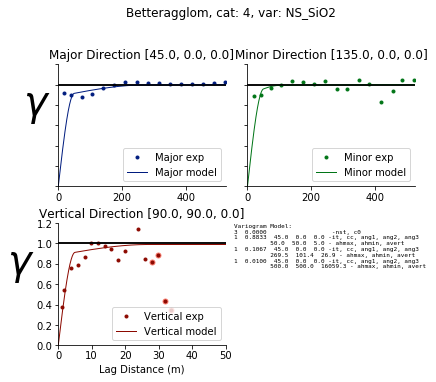

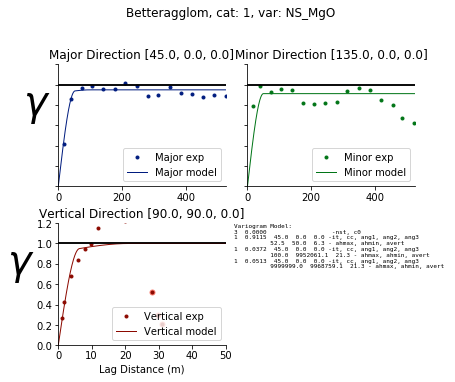

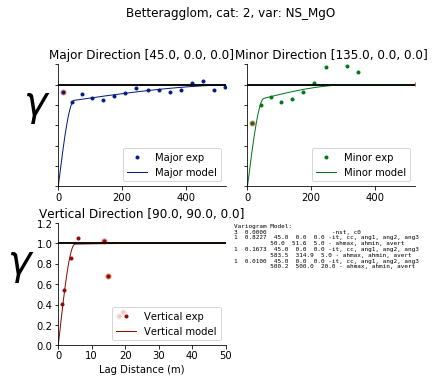

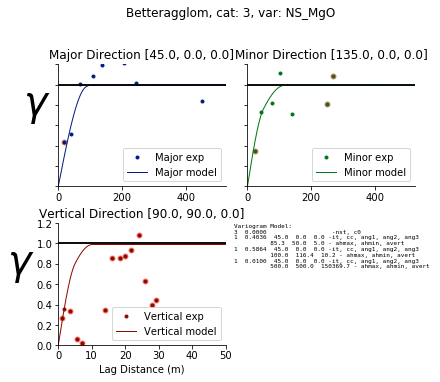

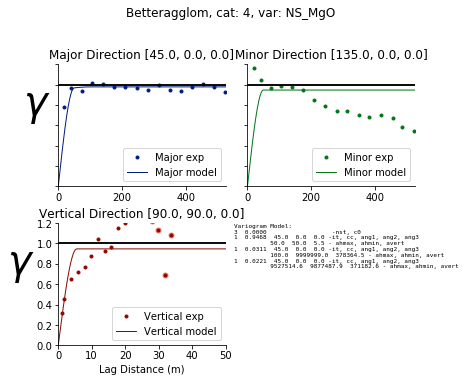

In [36]:
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    ncats = len(ucats)
    for var, nsvar in zip(variables, nsvariables):
        if ncats == 1:
            nsvarios[catcol, 1, var].plot(
                    model=True, printmodel=True, 
                    suptitle=f'{catcol.capitalize()}, var: {nsvar}',
                    varplt_kws={'exp': {'ms': 3}}
                )
        else:
            for cat in ucats:
                nsvarios[catcol, cat, var].plot(
                    model=True, printmodel=True, 
                    suptitle=f'{catcol.capitalize()}, cat: {cat}, var: {nsvar}',
                    varplt_kws={'exp': {'ms': 3}}
                )

In [43]:
nsvarmodels = {k: str(v.model) for k, v in nsvarios.items()}
# take the global model for random domains
for catcol in realscatcols[1]:
    for cat in ucats:
        for var in variables:
            nsvarmodels[catcol, cat, var] = nsvarios['nodomains', 1, var].model

In [44]:
# take the conensus model for the realizations
for catcol in realscatcols[0]:
    for cat in ucats:
        for var in variables:
            nsvarmodels[catcol, cat, var] = nsvarios['betteragglom', cat, var].model

In [45]:
gg.save_pickle(nsvarmodels, 'nsvarmodels.pkl')

# original units variogram models

In [40]:
ouvarios = {}
## SINGLE REALS
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    for cat in ucats:
        for var in variables:
            vario = gs.Variogram(points, var, ndim=3, ndir=3, omnihz=False, variostd=True,
                                 mute=True, tmin=ltrim, catpars=(catcol, cat))
            vario.inferdirections(0)
            calcpars = copy.deepcopy(contcalcpars[var][cat])
            vario.update_calcpars(variotypes=1, diptol=10.5, 
                                  **calcpars)
            modelpars = copy.deepcopy(contmodelpars[var][cat])
            modelpars.update(c0=[0.0, 0.0])
            vario.update_modelpars(**modelpars)
            ouvarios[catcol, cat, var] = vario
varcalc_parallel(ouvarios, nprocesses=nprocesses)
varfit_parallel(ouvarios, c0=[0, 0.1], it=[1, 1], minrange=10, nst=3, 
                nprocesses=nprocesses)

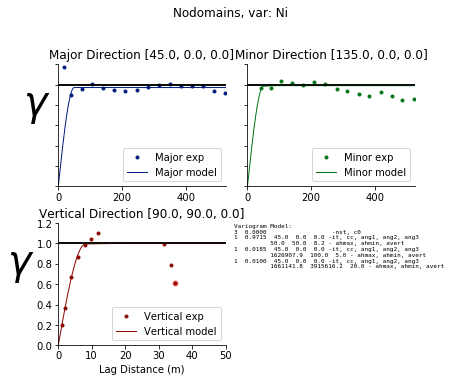

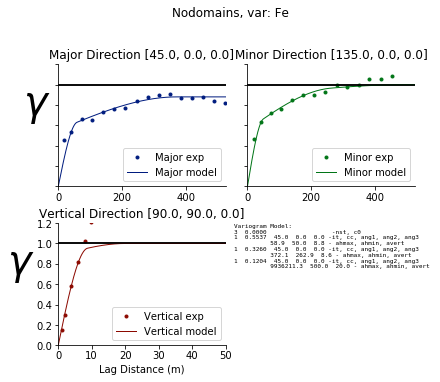

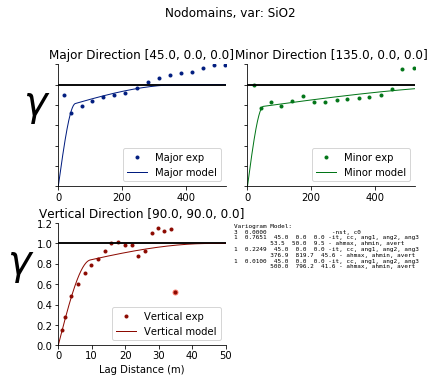

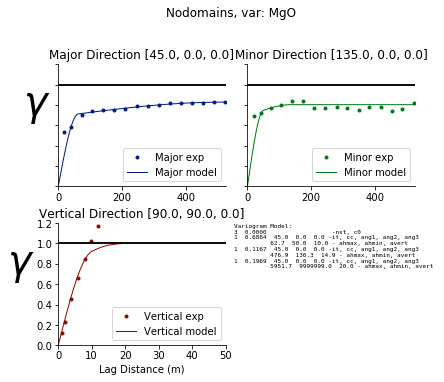

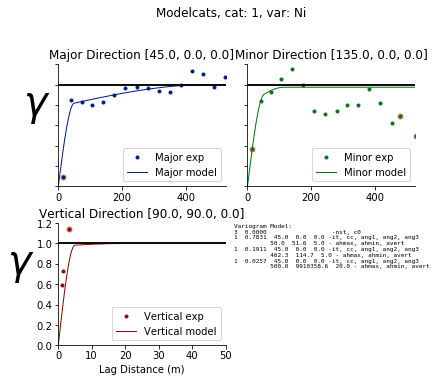

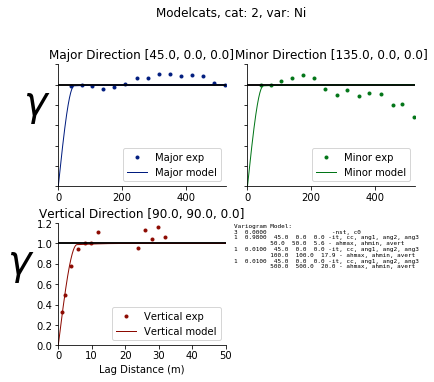

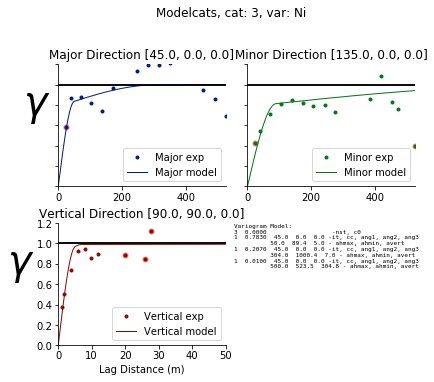

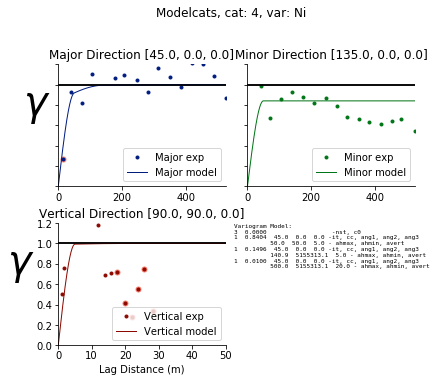

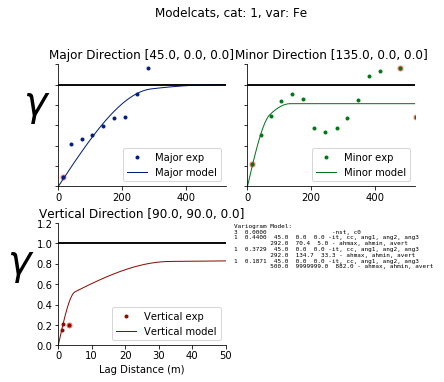

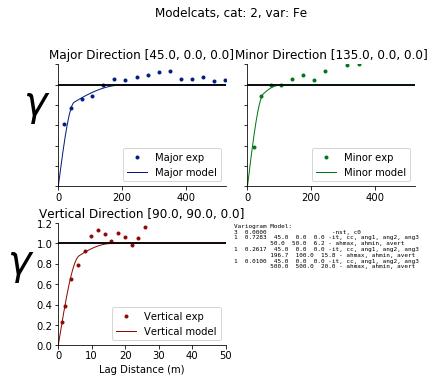

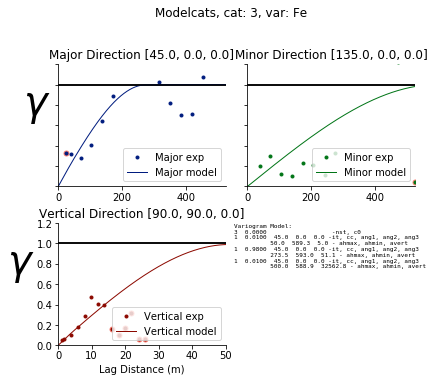

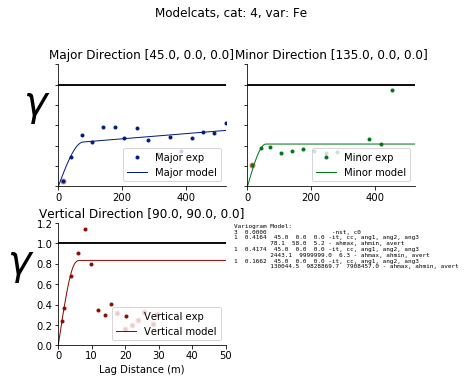

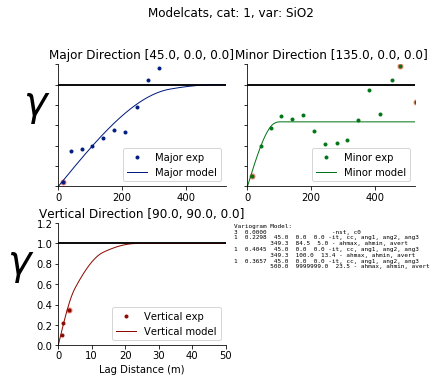

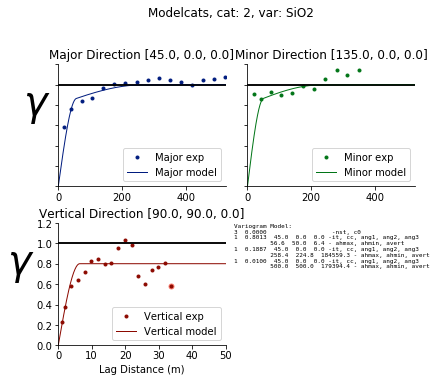

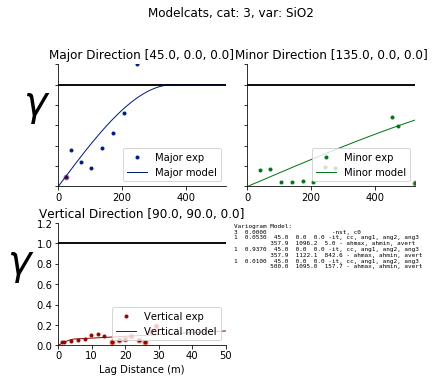

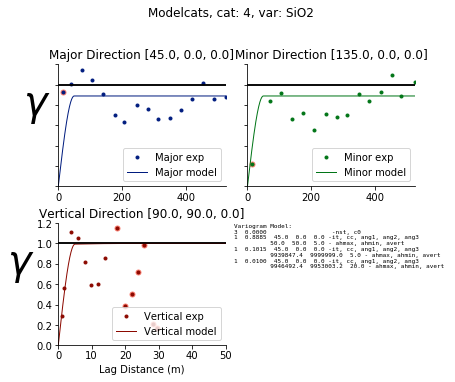

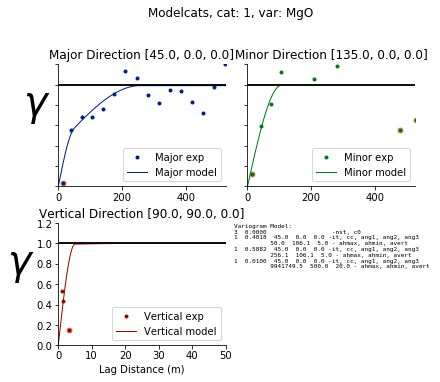

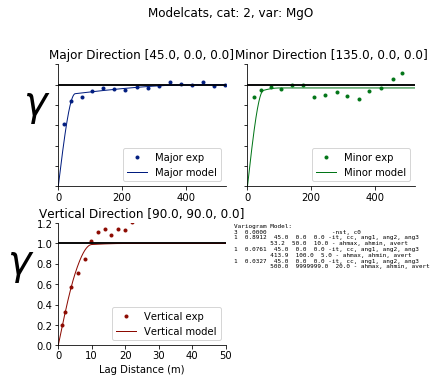

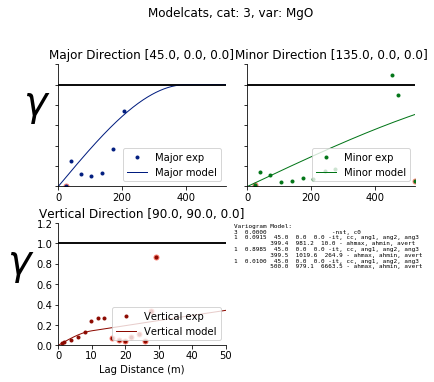

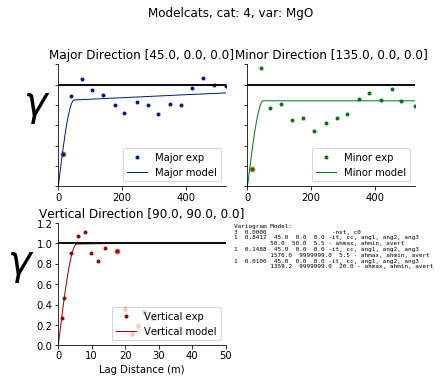

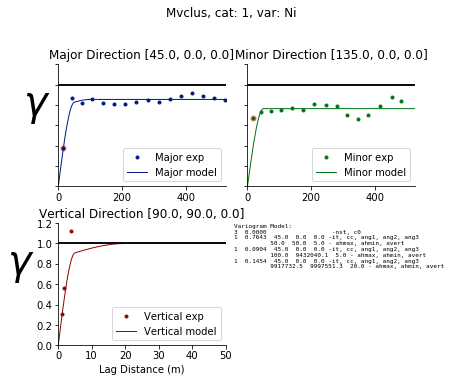

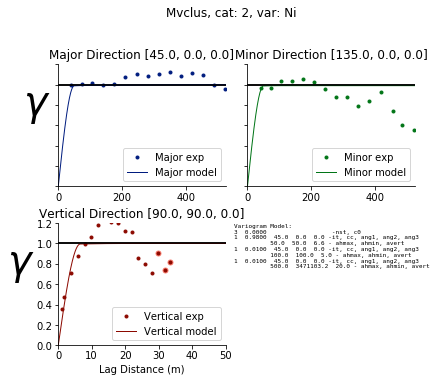

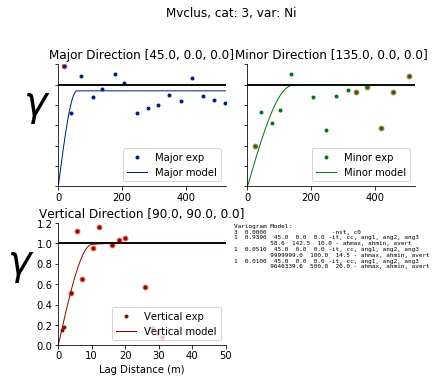

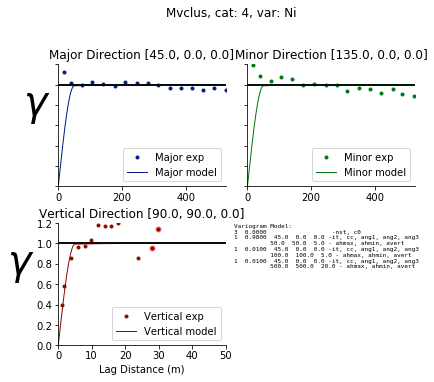

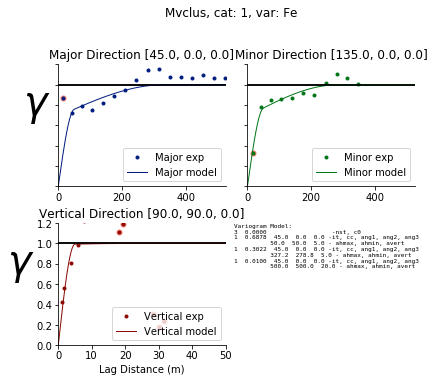

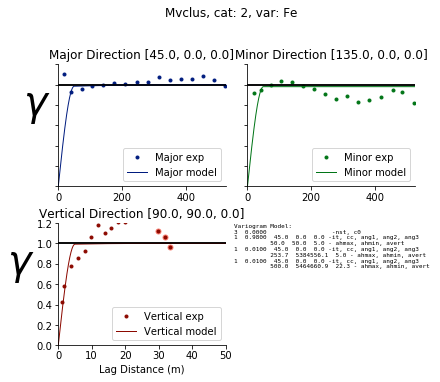

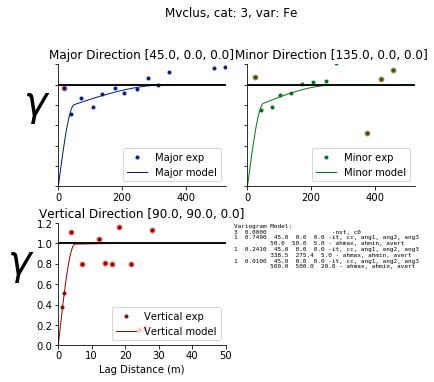

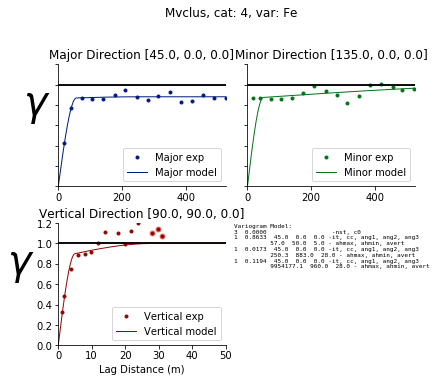

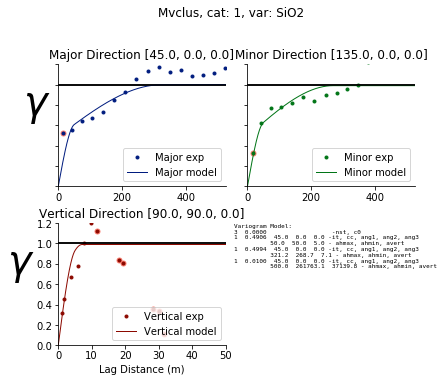

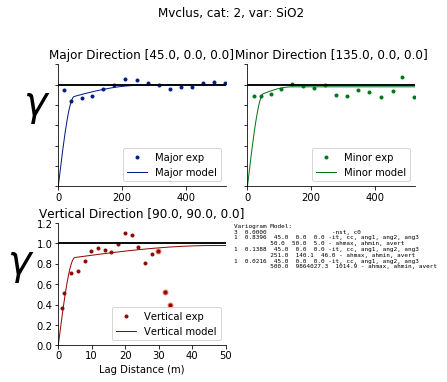

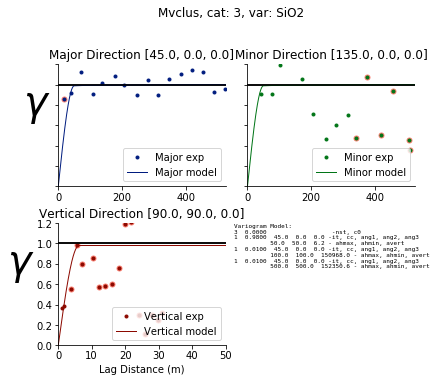

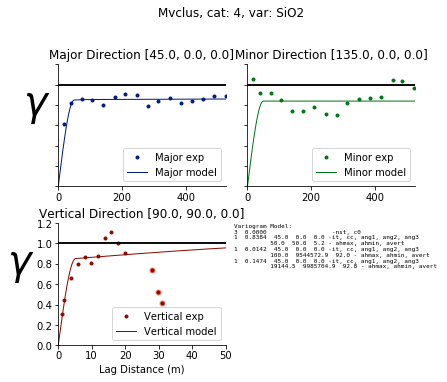

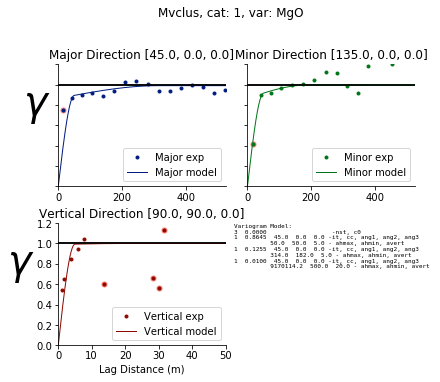

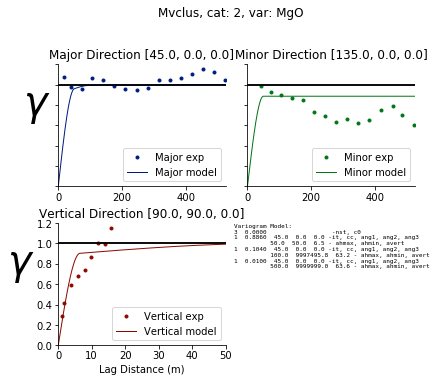

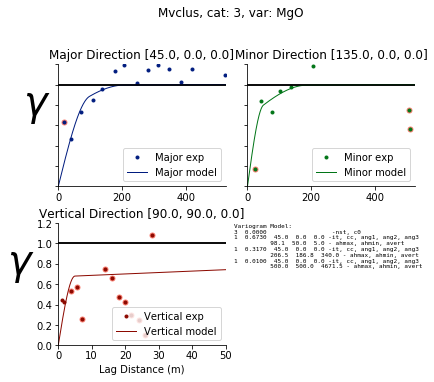

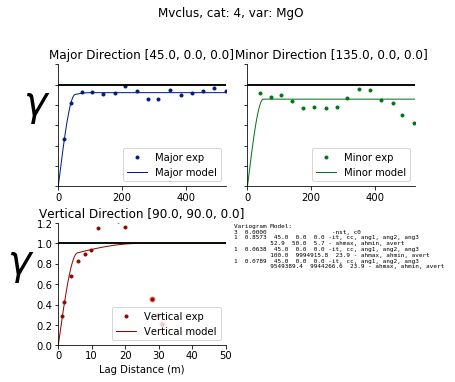

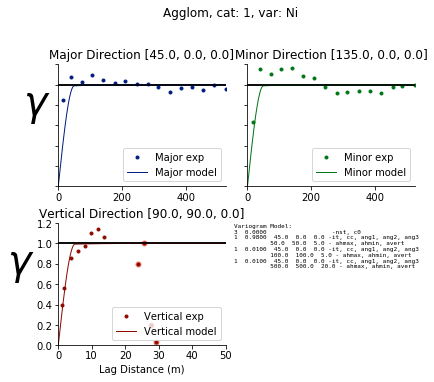

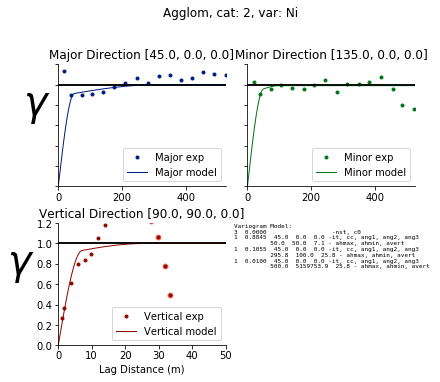

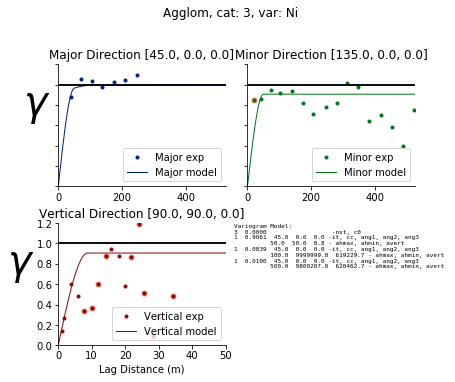

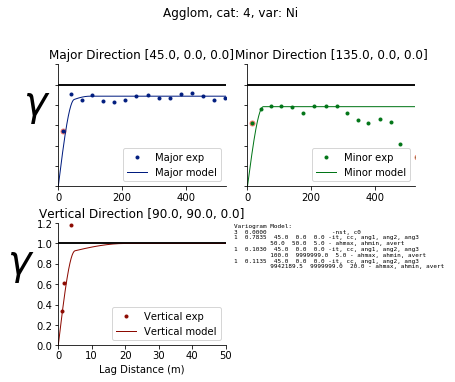

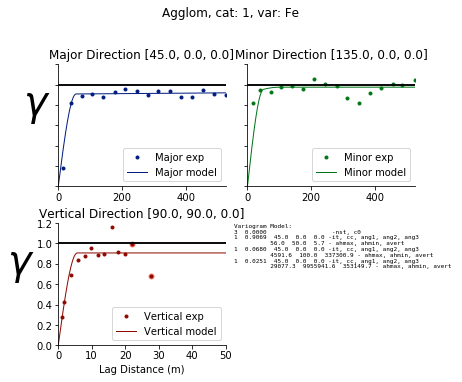

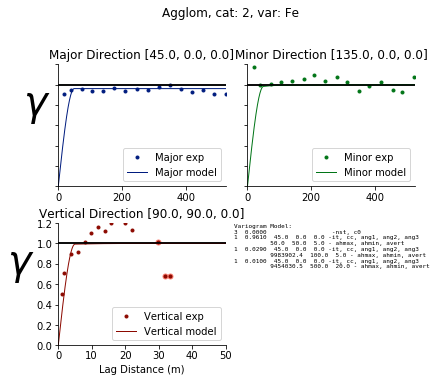

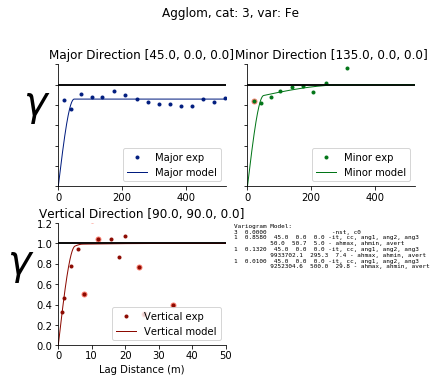

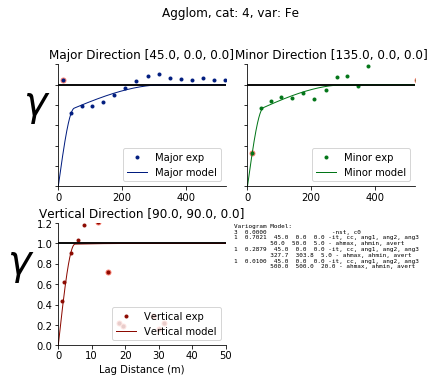

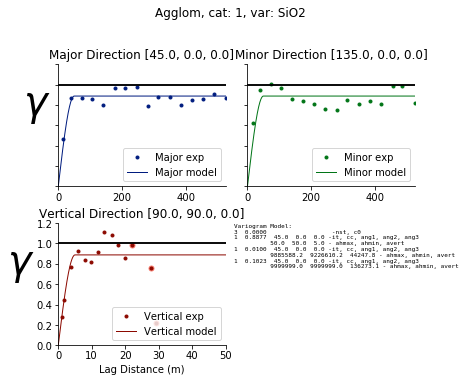

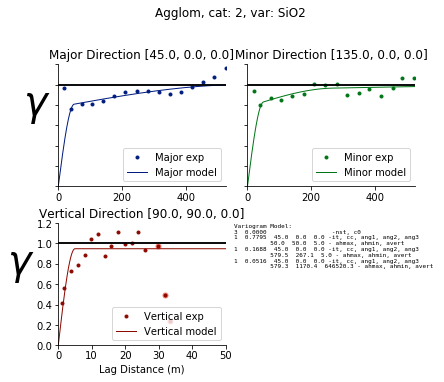

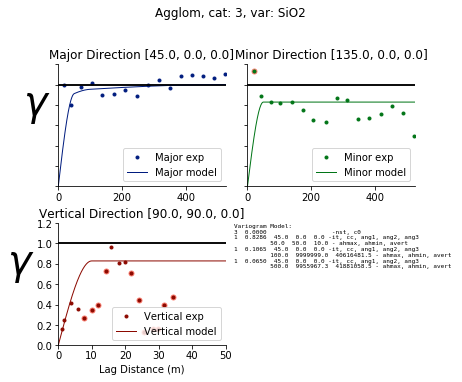

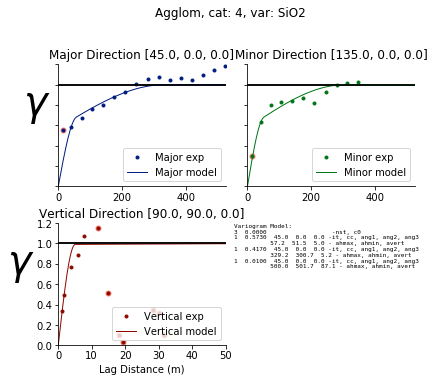

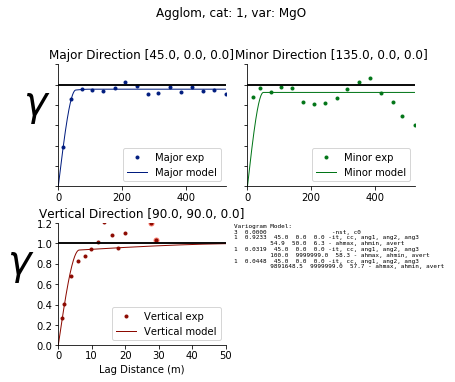

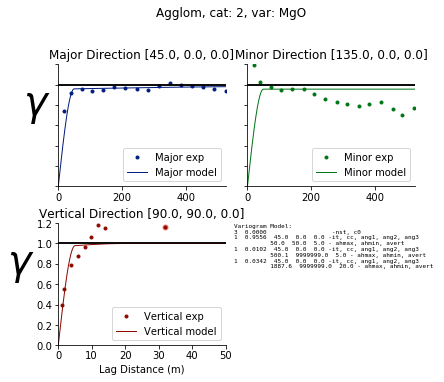

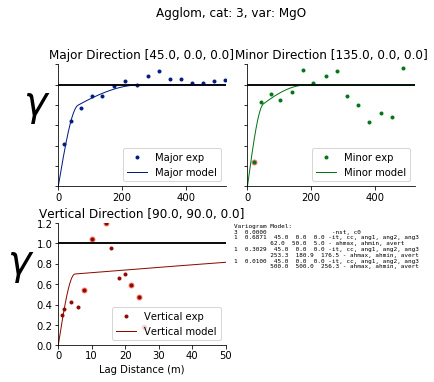

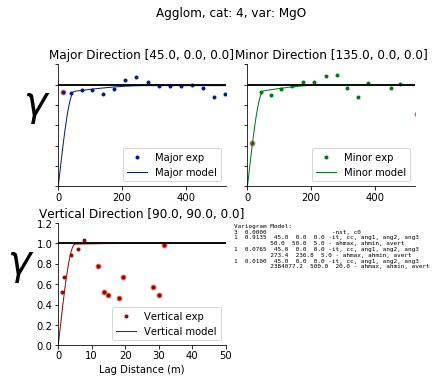

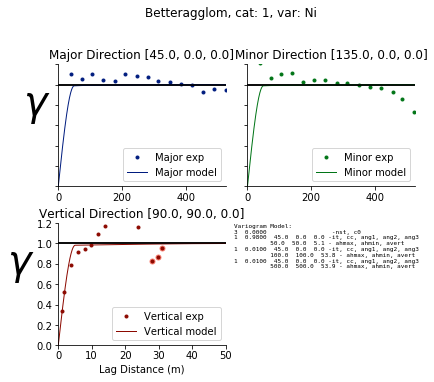

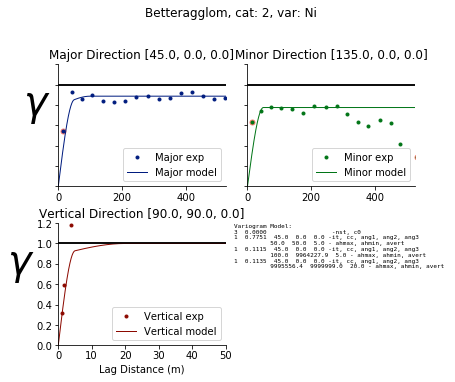

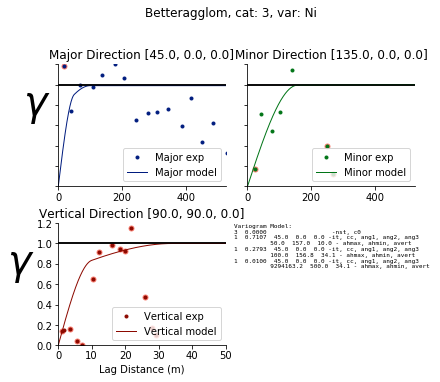

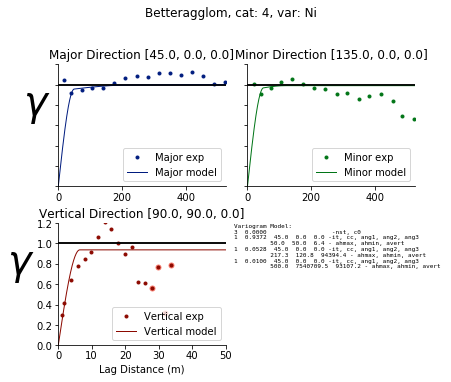

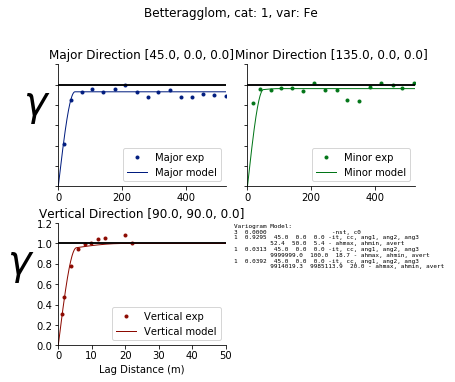

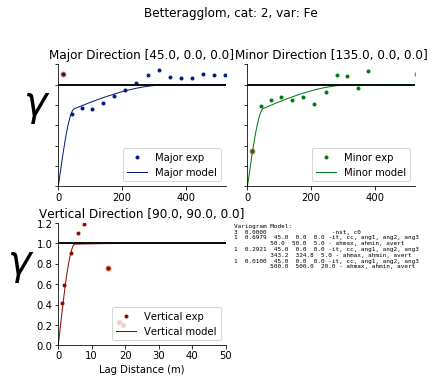

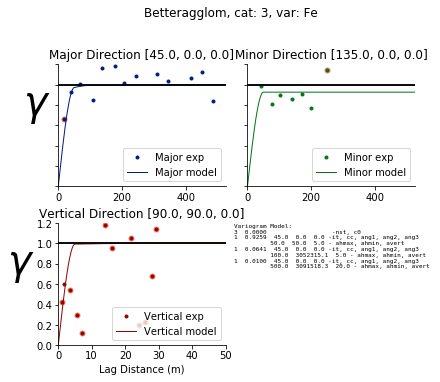

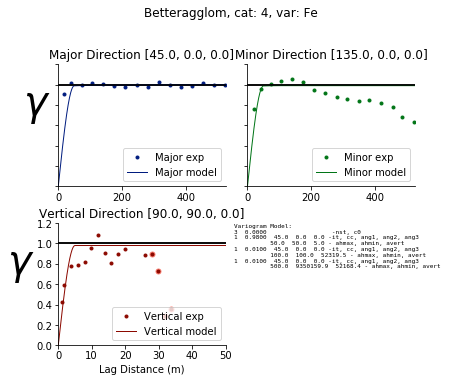

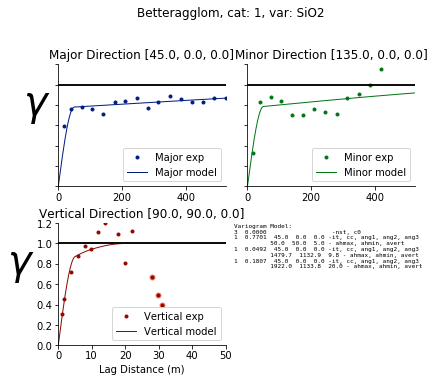

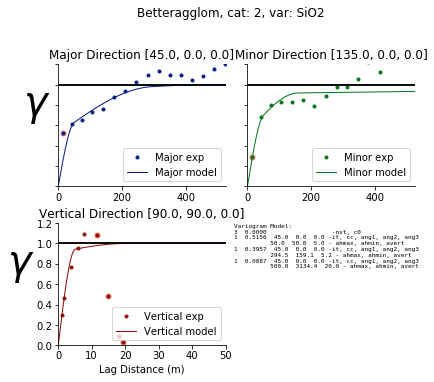

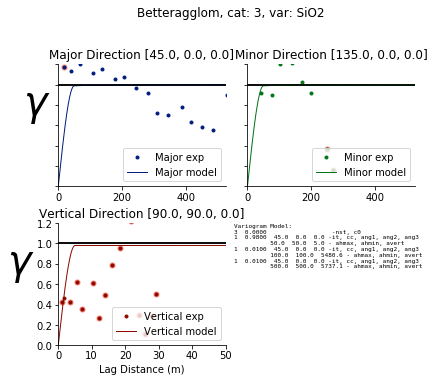

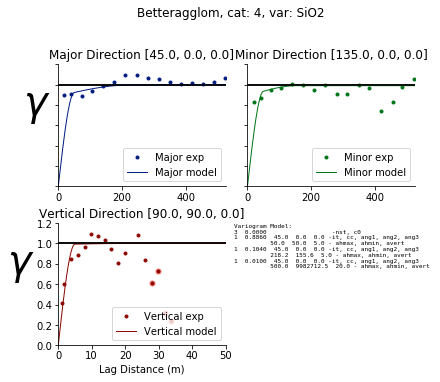

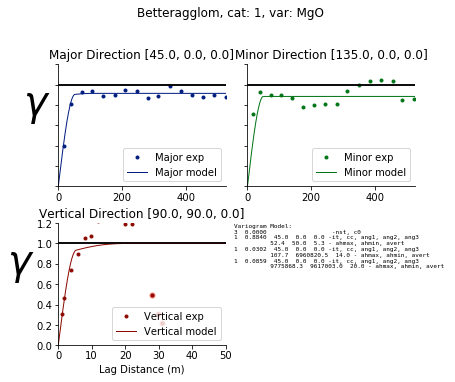

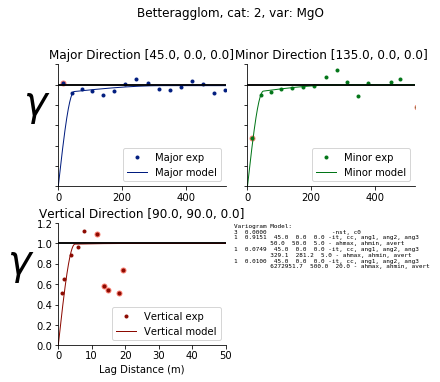

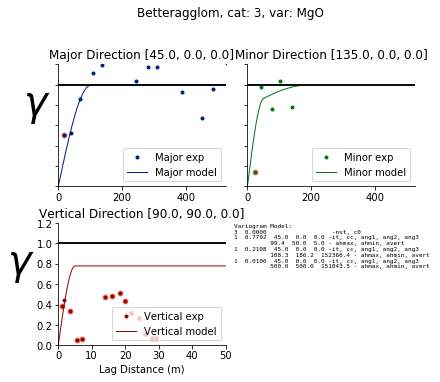

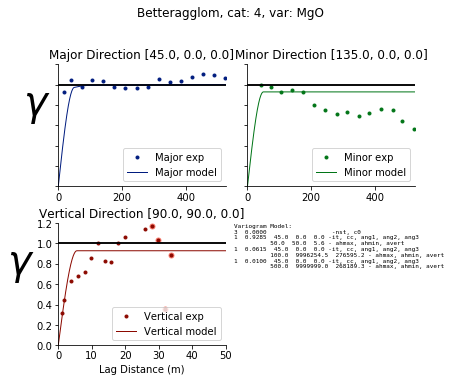

In [41]:
for catcol in catcols:
    ucats = np.unique(points[catcol]).astype(int)
    ncats = len(ucats)
    for var, nsvar in zip(variables, nsvariables):
        if ncats == 1:
            ouvarios[catcol, 1, var].plot(
                    model=True, printmodel=True, 
                    suptitle=f'{catcol.capitalize()}, var: {var}',
                    varplt_kws={'exp': {'ms': 3}}
                )
        else:
            for cat in ucats:
                ouvarios[catcol, cat, var].plot(
                    model=True, printmodel=True, 
                    suptitle=f'{catcol.capitalize()}, cat: {cat}, var: {var}',
                    varplt_kws={'exp': {'ms': 3}}
                )

In [42]:
ouvarmodels = {k: str(v.model) for k, v in ouvarios.items()}
gg.save_pickle(ouvarmodels, 'ouvarmodels.pkl')